/var/folders/np/6t9dnsq51cd5ps1kvznb19yw0000gn/T/ipykernel_9601/3294440028.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, _, _, _ = np.linalg.lstsq(A, b)


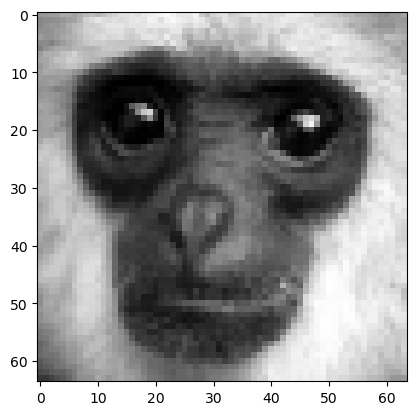

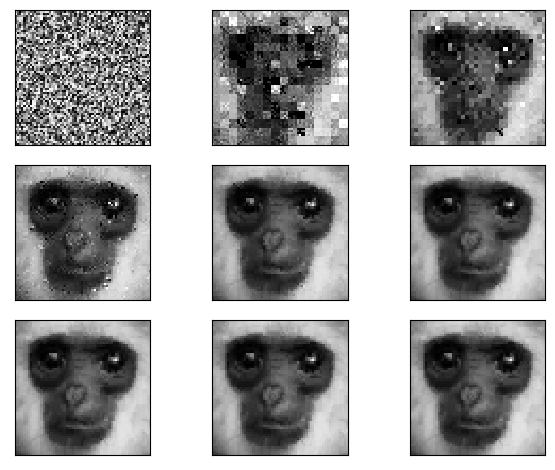

In [1]:
# code from git
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from scipy import optimize
import numpy as np
import math

# Manipulate channels

def get_greyscale_image(img):
    return np.mean(img[:,:,:2], 2)

def extract_rgb(img):
    return img[:,:,0], img[:,:,1], img[:,:,2]

def assemble_rbg(img_r, img_g, img_b):
    shape = (img_r.shape[0], img_r.shape[1], 1)
    return np.concatenate((np.reshape(img_r, shape), np.reshape(img_g, shape), 
        np.reshape(img_b, shape)), axis=2)

# Transformations

def reduce(img, factor):
    result = np.zeros((img.shape[0] // factor, img.shape[1] // factor))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i,j] = np.mean(img[i*factor:(i+1)*factor,j*factor:(j+1)*factor])
    return result

def rotate(img, angle):
    return ndimage.rotate(img, angle, reshape=False)

def flip(img, direction):
    return img[::direction,:]

def apply_transformation(img, direction, angle, contrast=1.0, brightness=0.0):
    return contrast*rotate(flip(img, direction), angle) + brightness

# Contrast and brightness

def find_contrast_and_brightness1(D, S):
    # Fix the contrast and only fit the brightness
    contrast = 0.75
    brightness = (np.sum(D - contrast*S)) / D.size
    return contrast, brightness 

def find_contrast_and_brightness2(D, S):
    # Fit the contrast and the brightness
    A = np.concatenate((np.ones((S.size, 1)), np.reshape(S, (S.size, 1))), axis=1)
    b = np.reshape(D, (D.size,))
    x, _, _, _ = np.linalg.lstsq(A, b)
    #x = optimize.lsq_linear(A, b, [(-np.inf, -2.0), (np.inf, 2.0)]).x
    return x[1], x[0]

# Compression for greyscale images

def generate_all_transformed_blocks(img, source_size, destination_size, step):
    factor = source_size // destination_size
    transformed_blocks = []
    for k in range((img.shape[0] - source_size) // step + 1):
        for l in range((img.shape[1] - source_size) // step + 1):
            # Extract the source block and reduce it to the shape of a destination block
            S = reduce(img[k*step:k*step+source_size,l*step:l*step+source_size], factor)
            # Generate all possible transformed blocks
            for direction, angle in candidates:
                transformed_blocks.append((k, l, direction, angle, apply_transformation(S, direction, angle)))
    return transformed_blocks

def compress(img, source_size, destination_size, step):
    transformations = []
    transformed_blocks = generate_all_transformed_blocks(img, source_size, destination_size, step)
    i_count = img.shape[0] // destination_size
    j_count = img.shape[1] // destination_size
    for i in range(i_count):
        transformations.append([])
        for j in range(j_count):
           # print("{}/{} ; {}/{}".format(i, i_count, j, j_count))
            transformations[i].append(None)
            min_d = float('inf')
            # Extract the destination block
            D = img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size]
            # Test all possible transformations and take the best one
            for k, l, direction, angle, S in transformed_blocks:
                contrast, brightness = find_contrast_and_brightness2(D, S)
                S = contrast*S + brightness
                d = np.sum(np.square(D - S))
                if d < min_d:
                    min_d = d
                    transformations[i][j] = (k, l, direction, angle, contrast, brightness)
    return transformations

def decompress(transformations, source_size, destination_size, step, nb_iter=8):
    factor = source_size // destination_size
    height = len(transformations) * destination_size
    width = len(transformations[0]) * destination_size
    iterations = [np.random.randint(0, 256, (height, width))]
    cur_img = np.zeros((height, width))
    for i_iter in range(nb_iter):
       # print(i_iter)
        for i in range(len(transformations)):
            for j in range(len(transformations[i])):
                # Apply transform
                k, l, flip, angle, contrast, brightness = transformations[i][j]
                S = reduce(iterations[-1][k*step:k*step+source_size,l*step:l*step+source_size], factor)
                D = apply_transformation(S, flip, angle, contrast, brightness)
                cur_img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size] = D
        iterations.append(cur_img)
        cur_img = np.zeros((height, width))
    return iterations

# Plot

def plot_iterations(iterations, target=None):
    # Configure plot
    plt.figure()
    nb_row = math.ceil(np.sqrt(len(iterations)))
    nb_cols = nb_row
    # Plot
    for i, img in enumerate(iterations):
        plt.subplot(nb_row, nb_cols, i+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
        #if target is None:
            #plt.title(str(i))
        #else:
            # Display the RMSE
            #plt.title(str(i) + ' (' + '{0:.2f}'.format(np.sqrt(np.mean(np.square(target - img)))) + ')')
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)
    plt.tight_layout()

# Parameters

directions = [1, -1]
angles = [0, 90, 180, 270]
candidates = [[direction, angle] for direction in directions for angle in angles]

# Tests

image_path1 = "monkey.gif"
#image_path2 = "/Users/sam/Desktop/project/image.jpeg"

def test_greyscale():
    img = mpimg.imread(image_path1)
    img = get_greyscale_image(img)
    img = reduce(img, 4)
    plt.figure()
    plt.imshow(img, cmap='gray', interpolation='none')
    transformations = compress(img, 8, 4, 8)
    iterations = decompress(transformations, 8, 4, 8)
    #print(iterations)
    plot_iterations(iterations, img)
    plt.show()

                    
if __name__ == '__main__':
    test_greyscale()

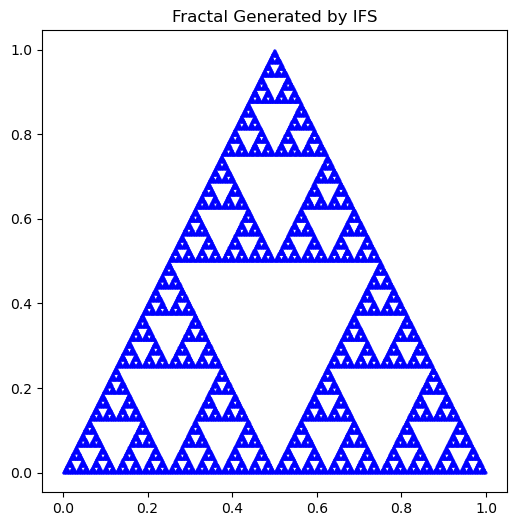

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# define affine_trans
def affine_transform(x, y, a, b, c, d, e, f):
    return a * x + b * y + e, c * x + d * y + f

# an exmample of affine_trans
transforms = [
    (0.5, 0, 0, 0.5, 0, 0),
    (0.5, 0, 0, 0.5, 0.5, 0),
    (0.5, 0, 0, 0.5, 0.25, 0.5)
]

# initial point
points = np.array([[0, 0]])

# iteration time
iterations = 10

for _ in range(iterations):
    new_points = []
    for x, y in points:
        for t in transforms:
            new_points.append(affine_transform(x, y, *t))
    points = np.array(new_points)

# image
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], s=0.1, color='blue')
plt.title('Fractal Generated by IFS')
plt.axis('equal')
#plt.savefig('trangle.png')
plt.show()


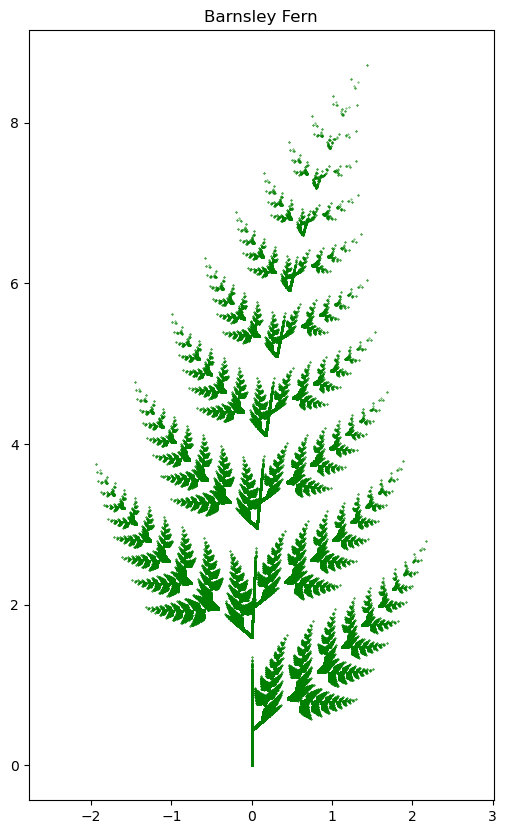

In [12]:
# Deterministic Algorithm


# Define the affine transformations
def affine_transform(x, y, a, b, c, d, e, f):
    return a * x + b * y + e, c * x + d * y + f

# Define the transformations for the Barnsley Fern
transforms = [
    (0.00,  0.00,  0.00,  0.16, 0.00, 0.00),   # Stem
    (0.85,  0.04, -0.04,  0.85, 0.00, 1.60),   # Successively smaller leaflets
    (0.20, -0.26,  0.23,  0.22, 0.00, 1.60),   # Largest left-hand leaflet
    (-0.15, 0.28,  0.26,  0.24, 0.00, 0.44)    # Largest right-hand leaflet
]

# Initialize points
points = np.array([[0, 0]])

# Number of iterations
iterations = 11

for _ in range(iterations):
    new_points = []
    for x, y in points:
        for t in transforms:
            new_points.append(affine_transform(x, y, *t))
    points = np.array(new_points)

# Plot the result
plt.figure(figsize=(6, 10))
plt.scatter(points[:, 0], points[:, 1], s=0.1, color='green')
plt.title('Barnsley Fern')
plt.axis('equal')
#plt.savefig('barnsley_fern.png')
plt.show()


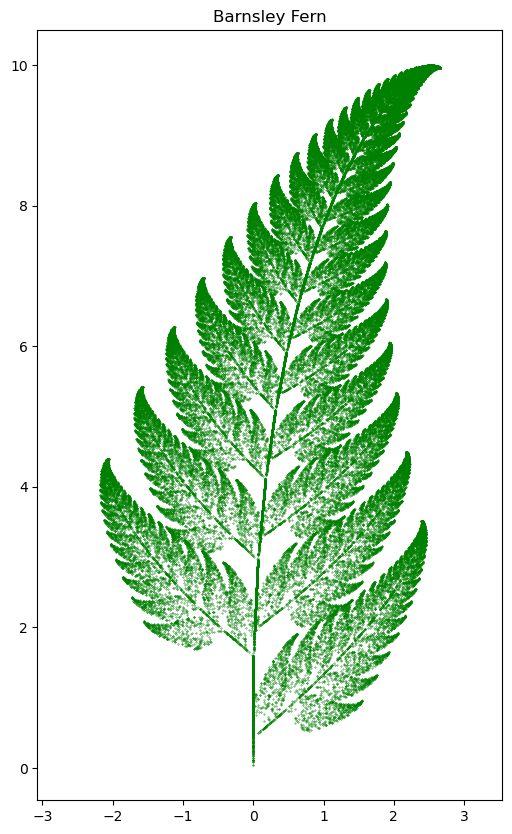

In [14]:
# Random Iteration Algorithm
import random

probabilities = [0.01, 0.85, 0.07, 0.07]

# Initialize the starting point
x, y = 0, 0

# Number of points to generate
num_points = 100000

# Lists to store the points
points = []

# Generate the points using the Random Iteration Algorithm
for _ in range(num_points):
    t = random.choices(transforms, probabilities)[0]
    x, y = affine_transform(x, y, *t)
    points.append((x, y))

# Convert points to a NumPy array for plotting
points = np.array(points)

# Plot the result
plt.figure(figsize=(6, 10))
plt.scatter(points[:, 0], points[:, 1], s=0.1, color='green')
plt.title('Barnsley Fern')
plt.axis('equal')
#plt.savefig('barnsley_fern_random.png')
plt.show()

In [3]:
# Adaptive Quadtree Coding Method
from scipy import ndimage

# A new transformation
def enlarge(img, factor):
    result = np.zeros((img.shape[0] * factor, img.shape[1] * factor))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j] = img[i // factor, j // factor]
    return result

def quadtree_decompose(img, threshold=256, min_size=2):
    """
    Decompose image using quadtree method.
    """
    def variance(block):
        return np.var(block)

    def decompose(block, x, y, size, threshold):
        if size <= min_size or variance(block) <= threshold:
            return [(x, y, size)]
        
        half = size // 2
        return (decompose(block[:half, :half], x, y, half, threshold) +
                decompose(block[:half, half:], x, y + half, half, threshold) +
                decompose(block[half:, :half], x + half, y, half, threshold) +
                decompose(block[half:, half:], x + half, y + half, half, threshold))
    
    return decompose(img, 0, 0, img.shape[0], threshold)

# Example usage
img = np.random.rand(16, 16)*255
quadtree_blocks = quadtree_decompose(img)


print(img)
print(quadtree_blocks[1])

[[ 29.04590404 233.95487633 106.22049732  49.64329667 201.00367041
  139.27410477 239.5093328   45.49706777  22.19536922 165.79908128
   94.13708576 223.45523273 128.84802104 195.10289221 202.47215159
   85.3849233 ]
 [235.28600338 174.81700633 208.94402196 192.18665958  72.57761579
  104.88415568   4.56730462  17.93656844  76.96910315 104.24449445
  201.10781198 135.51743079  25.98033384 131.67158946  56.47142592
  123.08088834]
 [ 23.61890813 101.16778156 219.62881029 238.47093032 167.57700453
  146.07611363 168.22066457 210.74130876  95.80520964 129.57534898
   42.78362181 128.52648653 235.8922332   32.82465757  78.46288932
  241.28193624]
 [156.51646575 136.99836118 188.50229259 197.41966002 217.37757104
  192.06977158 247.35816541 175.12304726  65.61602704  18.24686033
  100.70567312 161.64017304  60.14343326 213.59099825 183.47552302
  153.34217162]
 [ 66.63186086  66.19377613 104.21015904 236.92143633 142.86383249
  153.3544043   19.17444848  29.29920108  84.24518743 164.5476716

In [4]:
def generate_all_transformed_blocks_quadtree(img, quadtree_blocks):
    transformed_blocks = []
    for x, y, size_s in quadtree_blocks:
        S = img[x:x+size_s, y:y+size_s]
        for direction in [1, -1]:
            for angle in [0, 90, 180, 270]:
                transformed_S = apply_transformation(S, direction, angle)
                transformed_blocks.append((x, y, size_s, direction, angle, transformed_S))
    return transformed_blocks


def compress_with_quadtree(img, threshold=256, min_size=2):
    quadtree_blocks = quadtree_decompose(img, threshold, min_size)
    transformations = []
    transformed_blocks = generate_all_transformed_blocks_quadtree(img, quadtree_decompose(img, threshold, min_size*2))
    for x, y, size in quadtree_blocks:
        print(f"Processing block at ({x}, {y}) with size {size}")
        D = img[x:x+size, y:y+size]
        min_d = float('inf')
        best_transform = None
        for k, l, size_s, direction, angle, S in transformed_blocks:
            D_t = D
            if size_s <= size:
                continue
            else:
                D_t = enlarge(D_t, size_s//size)
            contrast, brightness = find_contrast_and_brightness2(D_t, S)
            transformed_S = contrast * S + brightness
            d = np.sum((D_t - transformed_S) ** 2)
            if d < min_d:
                min_d = d
                best_transform = (k, l, size_s, direction, angle, contrast, brightness)
        if best_transform == None:
            Number = img.shape[0]//(size*2)
            for i in range(Number):
                for j in range(Number):
                    S = img[i : i+size*2, j : j+size*2]
                    S = reduce(S, 2)
                    for direction in [1,-1]:
                        for angle in [0, 90, 180, 270]:
                            contrast, brightness = find_contrast_and_brightness2(D, S)
                            transformed_S = contrast * S + brightness
                            d = np.sum((D_t - transformed_S) ** 2)
                            if d < min_d:
                                min_d = d
                                best_transform = (i, j, size*2, direction, angle, contrast, brightness)
                            
        transformations.append((x, y, size) + best_transform)
    return img.shape, transformations


def decompress_with_quadtree(compressed_code, nb_iter = 8):
    height, width = compressed_code[0]
    transformations = compressed_code[1]
    iterations = [np.random.rand(height, width)*255]
    cur_img = np.zeros((height, width))
    for i_iter in range(nb_iter):
        print(i_iter)
        for x, y, size, k, l, size_s, direction, angle, contrast, brightness in transformations:
            S = iterations[-1][k:k+size_s, l:l+size_s]
            D = apply_transformation(S, direction, angle, contrast, brightness)
            if size_s != size:
                if size_s //size > 1:
                    D = reduce(D, size_s// size)
                else:
                    D = enlarge(D, size // size_s)
            cur_img[x:x+size, y:y+size] = D
        iterations.append(cur_img)
    return iterations


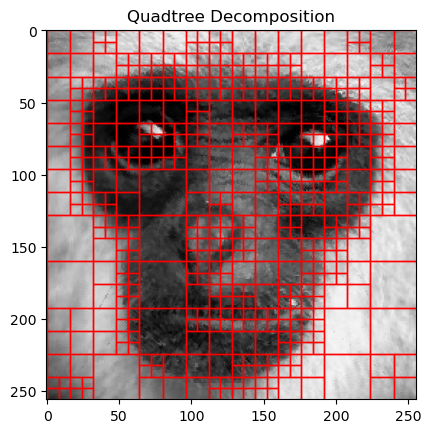

Processing block at (0, 0) with size 16
Processing block at (0, 16) with size 16


/var/folders/np/6t9dnsq51cd5ps1kvznb19yw0000gn/T/ipykernel_9601/3294440028.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, _, _, _ = np.linalg.lstsq(A, b)


Processing block at (16, 0) with size 16
Processing block at (16, 16) with size 16
Processing block at (0, 32) with size 8
Processing block at (0, 40) with size 8
Processing block at (8, 32) with size 8
Processing block at (8, 40) with size 8
Processing block at (0, 48) with size 16
Processing block at (16, 32) with size 16
Processing block at (16, 48) with size 8
Processing block at (16, 56) with size 8
Processing block at (24, 48) with size 8
Processing block at (24, 56) with size 8
Processing block at (32, 0) with size 16
Processing block at (32, 16) with size 8
Processing block at (32, 24) with size 8
Processing block at (40, 16) with size 8
Processing block at (40, 24) with size 8
Processing block at (48, 0) with size 16
Processing block at (48, 16) with size 8
Processing block at (48, 24) with size 8
Processing block at (56, 16) with size 8
Processing block at (56, 24) with size 8
Processing block at (32, 32) with size 8
Processing block at (32, 40) with size 8
Processing block a

Processing block at (24, 232) with size 8
Processing block at (16, 240) with size 16
Processing block at (32, 192) with size 8
Processing block at (32, 200) with size 8
Processing block at (40, 192) with size 8
Processing block at (40, 200) with size 8
Processing block at (32, 208) with size 8
Processing block at (32, 216) with size 8
Processing block at (40, 208) with size 8
Processing block at (40, 216) with size 8
Processing block at (48, 192) with size 8
Processing block at (48, 200) with size 8
Processing block at (56, 192) with size 8
Processing block at (56, 200) with size 8
Processing block at (48, 208) with size 8
Processing block at (48, 216) with size 8
Processing block at (56, 208) with size 8
Processing block at (56, 216) with size 8
Processing block at (32, 224) with size 16
Processing block at (32, 240) with size 8
Processing block at (32, 248) with size 8
Processing block at (40, 240) with size 8
Processing block at (40, 248) with size 8
Processing block at (48, 224) wi

Processing block at (248, 0) with size 8
Processing block at (248, 8) with size 8
Processing block at (240, 16) with size 8
Processing block at (240, 24) with size 8
Processing block at (248, 16) with size 8
Processing block at (248, 24) with size 8
Processing block at (224, 32) with size 32
Processing block at (192, 64) with size 32
Processing block at (192, 96) with size 8
Processing block at (192, 104) with size 8
Processing block at (200, 96) with size 8
Processing block at (200, 104) with size 8
Processing block at (192, 112) with size 8
Processing block at (192, 120) with size 8
Processing block at (200, 112) with size 8
Processing block at (200, 120) with size 8
Processing block at (208, 96) with size 16
Processing block at (208, 112) with size 16
Processing block at (224, 64) with size 8
Processing block at (224, 72) with size 8
Processing block at (232, 64) with size 8
Processing block at (232, 72) with size 8
Processing block at (224, 80) with size 16
Processing block at (240

In [30]:
img = mpimg.imread(image_path1)
img = get_greyscale_image(img)

# quadtree_blocks
quadtree_blocks = quadtree_decompose(img, threshold=256, min_size=8)

# visualize
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
for x, y, size in quadtree_blocks:
    rect = plt.Rectangle((y, x), size, size, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.title("Quadtree Decomposition")
plt.show()

# compress
transformations_quadtree = compress_with_quadtree(img, threshold=256, min_size=8)



0
1
2
3
4
5
6
7


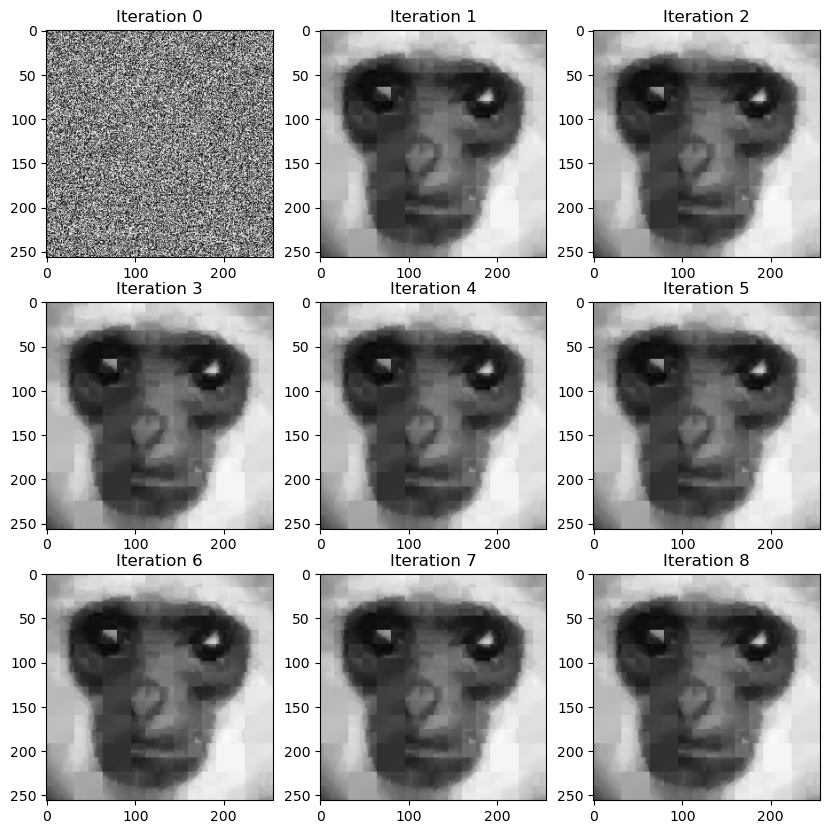

In [24]:
# decompress
iterations_with_quadtree = decompress_with_quadtree(transformations_quadtree)

# result
plt.figure(figsize=(10, 10))
for i in range(len(iterations_with_quadtree)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(iterations_with_quadtree[i], cmap='gray')
    plt.title(f'Iteration {i}')
plt.show()

In [17]:
transformations = compress(img, 8, 4, 8)
iterations = decompress(transformations, 8, 4, 8)

/var/folders/np/6t9dnsq51cd5ps1kvznb19yw0000gn/T/ipykernel_9601/3294440028.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, _, _, _ = np.linalg.lstsq(A, b)


In [27]:
# Neighborhood

def generate_all_transformed_blocks_nei(img, source_size, destination_size, step, neighborhood_size):
    factor = source_size // destination_size
    transformed_blocks = []
    candidates = [(1, 0), (1, 90), (1, 180), (1, 270), (-1, 0), (-1, 90), (-1, 180), (-1, 270)]
    
    for i in range(0, img.shape[0], destination_size):
        transformed_blocks.append([])
        for j in range(0, img.shape[1], destination_size):
            transformed_blocks[i//destination_size].append([])
            for k in range(max(0, i - neighborhood_size), min(img.shape[0] - source_size + 1, i + neighborhood_size), step):
                for l in range(max(0, j - neighborhood_size), min(img.shape[1] - source_size + 1, j + neighborhood_size), step):
                    # Extract the source block and reduce it to the shape of a destination block
                    S = reduce(img[k:k+source_size, l:l+source_size], factor)
                    # Generate all possible transformed blocks
                    for direction, angle in candidates:
                        transformed_blocks[i//destination_size][j//destination_size].append((k//step, l//step, direction, angle, apply_transformation(S, direction, angle)))
    return transformed_blocks



def compress_nei(img, source_size, destination_size, step, neighborhood_size):
    transformations = []
    transformed_blocks = generate_all_transformed_blocks_nei(img, source_size, destination_size, step, neighborhood_size)
    i_count = img.shape[0] // destination_size
    j_count = img.shape[1] // destination_size
    for i in range(i_count):
        transformations.append([])
        for j in range(j_count):
            #print("{}/{} ; {}/{}".format(i, i_count, j, j_count))
            transformations[i].append(None)
            min_d = float('inf')
            # Extract the destination block
            D = img[i*destination_size:(i+1)*destination_size, j*destination_size:(j+1)*destination_size]
            # Test all possible transformations and take the best one
            for k, l, direction, angle, S in transformed_blocks[i][j]:
                contrast, brightness = find_contrast_and_brightness2(D, S)
                S = contrast * S + brightness
                d = np.sum(np.square(D - S))
                if d < min_d:
                    min_d = d
                    transformations[i][j] = (k, l, direction, angle, contrast, brightness)
    return transformations

def decompress(transformations, source_size, destination_size, step, nb_iter=8):
    factor = source_size // destination_size
    height = len(transformations) * destination_size
    width = len(transformations[0]) * destination_size
    iterations = [np.random.randint(0, 256, (height, width))]
    cur_img = np.zeros((height, width))
    for i_iter in range(nb_iter):
        #print(i_iter)
        for i in range(len(transformations)):
            for j in range(len(transformations[i])):
                # Apply transform
                k, l, flip, angle, contrast, brightness = transformations[i][j]
                S = reduce(iterations[-1][k*step:k*step+source_size,l*step:l*step+source_size], factor)
                D = apply_transformation(S, flip, angle, contrast, brightness)
                cur_img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size] = D
        iterations.append(cur_img)
        cur_img = np.zeros((height, width))
    return iterations

/var/folders/np/6t9dnsq51cd5ps1kvznb19yw0000gn/T/ipykernel_9601/3294440028.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, _, _, _ = np.linalg.lstsq(A, b)


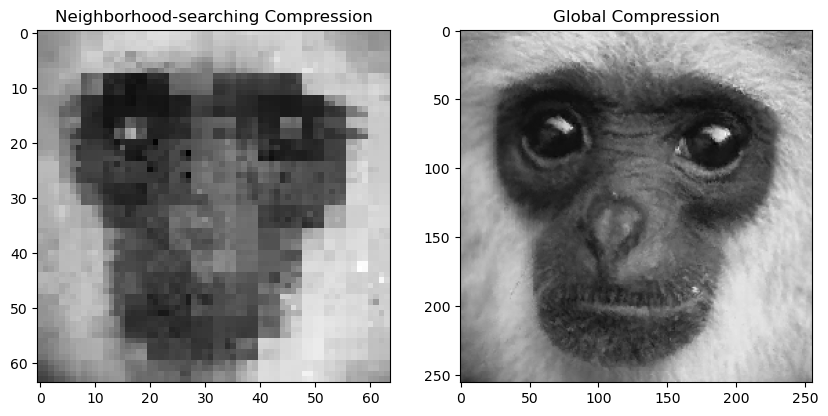

In [29]:
from IPython.display import display, HTML
import time
from skimage import data, color

def print_large(text):
    display(HTML(f"<div style='font-size:25px'>{text}</div>"))

img1 = reduce(img,4)
    
#transformations and time of neighbourhood method
start_time = time.time()
transformations_nei= compress_nei(img1, 8, 4, 8, 4)
nei_time = time.time() - start_time

#transformations and time of global method
start_time = time.time()
transformations1 = compress(img1, 8, 4, 8)
global_time = time.time() - start_time

iterations_class = decompress(transformations_nei, 8, 4, 8)
iterations1 = decompress(transformations, 8, 4, 8)


plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(iterations_class[-1], cmap='gray')
plt.title('Neighborhood-searching Compression')

plt.subplot(1, 2, 2)
plt.imshow(iterations[-1], cmap='gray')
plt.title('Global Compression')
plt.show()
print_large(f"Global compression time: {global_time:.4f} seconds")
print_large(f"Neighborhood-searching compression time: {nei_time:.4f} seconds")

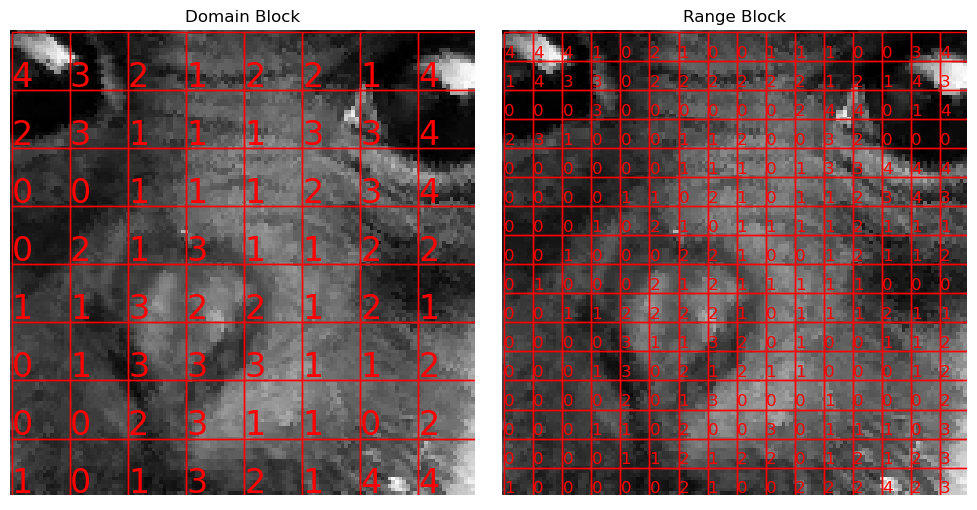

In [47]:
# Classification

def classify_blocks_by_variance(img, block_size, thresholds):
    h, w = img.shape
    variance_classes = []
    for _ in range(len(thresholds)+1):
        variance_classes.append([])
    
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = img[i:i+block_size, j:j+block_size]
            class_label = classify_variance(block, thresholds)
            variance_classes[class_label].append((i, j, block_size))
    
    return variance_classes

def classify_variance(block, thresholds):
    for i, threshold in enumerate(thresholds):
        if np.var(block) < threshold:
            return i
    return len(thresholds)


# Classes by var

thresholds = [128, 256, 512, 1024]

# visualize classification
def visualize_classification(img, variance_classes, block_size, title):
    plt.imshow(img, cmap='gray')
    for n in range(len(variance_classes)):
        for (i, j, size) in variance_classes[n]:
            rect = plt.Rectangle((j, i), size, size, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(j, i+block_size-1, str(n), color='red', fontsize=block_size*1.5)
    plt.title(title)
    plt.axis('off')

# taking a suitable part of the image and generating classes of domain and range
img = mpimg.imread(image_path1)
img = get_greyscale_image(img)
domain_block = img[64:192, 64:192]
range_block = img[64:192, 64:192]
domain_classes = classify_blocks_by_variance(domain_block, 16, thresholds)
range_classes = classify_blocks_by_variance(range_block, 8, thresholds)


# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 10))


plt.subplot(2, 2, 1)
visualize_classification(domain_block, domain_classes, 16, 'Domain Block')

plt.subplot(2, 2, 2)
visualize_classification(range_block, range_classes, 8, 'Range Block')


plt.tight_layout()
plt.savefig('classification1.png')
plt.show()

In [33]:
def classify_variance(block, thresholds):
    for i, threshold in enumerate(thresholds):
        if np.var(block) < threshold:
            return i
    return len(thresholds)

def generate_all_transformed_blocks_class(img, source_size, destination_size, step, thresholds):
    transformed_blocks = []
    for _ in range(len(thresholds)+1):
        transformed_blocks.append([])
    factor = source_size // destination_size
    for k in range((img.shape[0] - source_size) // step + 1):
        for l in range((img.shape[1] - source_size) // step + 1):
            # Extract the source block and reduce it to the shape of a destination block
            S = reduce(img[k*step:k*step+source_size,l*step:l*step+source_size], factor)
            # Generate all possible transformed blocks
            class_label = classify_variance(S, thresholds)
            for direction, angle in candidates:
                transformed_blocks[class_label].append((k, l, direction, angle, apply_transformation(S, direction, angle)))
    return transformed_blocks

def compress_class(img, source_size, destination_size, step, thresholds):
    transformations = []
    transformed_blocks = generate_all_transformed_blocks_class(img, source_size, destination_size, step, thresholds)
    i_count = img.shape[0] // destination_size
    j_count = img.shape[1] // destination_size
    for i in range(i_count):
        transformations.append([])
        for j in range(j_count):
            #print("{}/{} ; {}/{}".format(i, i_count, j, j_count))
            transformations[i].append(None)
            min_d = float('inf')
            # Extract the destination block
            D = img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size]
            # Test all possible transformations and take the best one
            class_label = classify_variance(D, thresholds)
            for k, l, direction, angle, S in transformed_blocks[class_label]:
                contrast, brightness = find_contrast_and_brightness2(D, S)
                S = contrast*S + brightness
                d = np.sum(np.square(D - S))
                if d < min_d:
                    min_d = d
                    transformations[i][j] = (k, l, direction, angle, contrast, brightness)
    return transformations

def decompress(transformations, source_size, destination_size, step, nb_iter=8):
    factor = source_size // destination_size
    height = len(transformations) * destination_size
    width = len(transformations[0]) * destination_size
    iterations = [np.random.randint(0, 256, (height, width))]
    cur_img = np.zeros((height, width))
    for i_iter in range(nb_iter):
        #print(i_iter)
        for i in range(len(transformations)):
            for j in range(len(transformations[i])):
                # Apply transform
                k, l, flip, angle, contrast, brightness = transformations[i][j]
                S = reduce(iterations[-1][k*step:k*step+source_size,l*step:l*step+source_size], factor)
                D = apply_transformation(S, flip, angle, contrast, brightness)
                cur_img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size] = D
        iterations.append(cur_img)
        cur_img = np.zeros((height, width))
    return iterations

/var/folders/np/6t9dnsq51cd5ps1kvznb19yw0000gn/T/ipykernel_9601/3294440028.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, _, _, _ = np.linalg.lstsq(A, b)


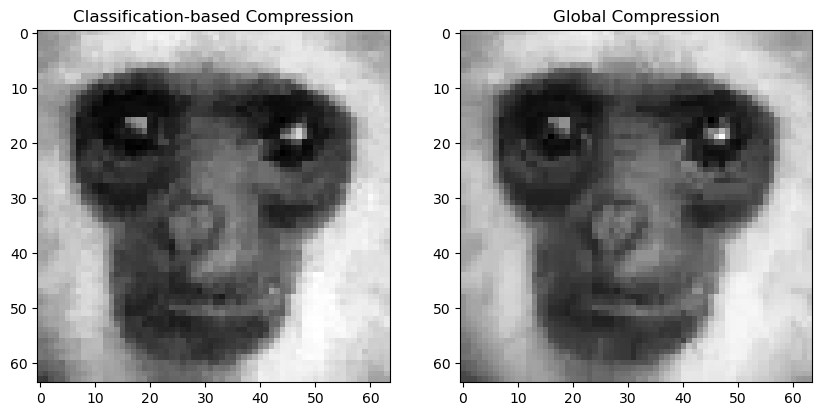

In [34]:
import time
from skimage import data, color

img = mpimg.imread(image_path1)
img = get_greyscale_image(img)
img = reduce(img, 4)
thresholds = [128, 256, 512, 1024]
destination_size = 16  # 设置目标块大小

start_time = time.time()
transformations_class = compress_class(img, 8, 4, 8, thresholds)
classification_time = time.time() - start_time

start_time = time.time()
transformations = compress(img, 8, 4, 8)
global_time = time.time() - start_time
# 解压缩
iterations_class = decompress(transformations_class, 8, 4, 8)
iterations = decompress(transformations, 8, 4, 8)

# 显示结果
#plt.figure(figsize=(10, 10))
#for i in range(len(iterations)):
 #   plt.subplot(3, 3, i + 1)
  #  plt.imshow(iterations[i], cmap='gray')
   # plt.title(f'Iteration {i}')
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(iterations_class[-1], cmap='gray')
plt.title('Classification-based Compression')

plt.subplot(1, 2, 2)
plt.imshow(iterations[-1], cmap='gray')
plt.title('Global Compression')
plt.show()
print_large(f"Global compression time: {global_time:.4f} seconds")
print_large(f"Classification-based compression time: {classification_time:.4f} seconds")

In [52]:
# Mean subtraction
def generate_all_transformed_blocks_class_ms(img, source_size, destination_size, step, thresholds):
    transformed_blocks = [[] for _ in range(len(thresholds) + 1)]
    factor = source_size // destination_size
    candidates = [(1, 0), (1, 90), (1, 180), (1, 270), (-1, 0), (-1, 90), (-1, 180), (-1, 270)]
    
    for k in range((img.shape[0] - source_size) // step + 1):
        for l in range((img.shape[1] - source_size) // step + 1):
            S = reduce(img[k * step:k * step + source_size, l * step:l * step + source_size], factor)
            class_label = classify_variance(np.var(S), thresholds)
            for direction, angle in candidates:
                transformed_blocks[class_label].append((k, l, direction, angle, apply_transformation(S, direction, angle)))
    
    return transformed_blocks

def compress_class_ms(img, source_size, destination_size, step, thresholds):
    transformations = []
    transformed_blocks = generate_all_transformed_blocks_class_ms(img, source_size, destination_size, step, thresholds)
    i_count = img.shape[0] // destination_size
    j_count = img.shape[1] // destination_size
    
    for i in range(i_count):
        transformations.append([])
        for j in range(j_count):
            min_d = float('inf')
            D = img[i * destination_size:(i + 1) * destination_size, j * destination_size:(j + 1) * destination_size]
            mean_D = np.mean(D)
            D = D - mean_D
            class_label = classify_variance(np.var(D), thresholds)
            
            for k, l, direction, angle, S in transformed_blocks[class_label]:
                contrast, brightness = find_contrast_and_brightness2(D, S)
                S_transformed = contrast * S + brightness
                d = np.sum(np.square(D - S_transformed))
                if d < min_d:
                    min_d = d
                    best_transform = (k, l, direction, angle, contrast, brightness, mean_D)
            
            transformations[i].append(best_transform)
    
    return transformations

# Function to decompress image
def decompress_ms(transformations, source_size, destination_size, step, nb_iter=8):
    factor = source_size // destination_size
    height = len(transformations) * destination_size
    width = len(transformations[0]) * destination_size
    iterations = [np.random.randint(0, 256, (height, width))]
    cur_img = np.zeros((height, width))
    
    for i_iter in range(nb_iter):
        #print(f"Iteration {i_iter}")
        for i in range(len(transformations)):
            for j in range(len(transformations[i])):
                k, l, direction, angle, contrast, brightness, mean_D = transformations[i][j]
                S = reduce(iterations[-1][k * step:k * step + source_size, l * step:l * step + source_size], factor)
                D = apply_transformation(S, direction, angle, contrast, brightness)
                D = D + mean_D
                cur_img[i * destination_size:(i + 1) * destination_size, j * destination_size:(j + 1) * destination_size] = D
        iterations.append(cur_img)
        cur_img = np.zeros((height, width))
    
    return iterations

In [57]:
img = mpimg.imread(image_path1)
img = get_greyscale_image(img)
img = reduce(img, 4)
thresholds = [128, 256, 512, 1024]
destination_size = 16 




transformations_class_ms = compress_class_ms(img, 8, 4, 8, thresholds)
# 解压缩
iterations1 = decompress_ms(transformations_class_ms, 8, 4, 8)

transformations_class = compress_class(img, 8, 4, 8, thresholds)
iterations = decompress(transformations_class, 8, 4, 8)

# 显示结果


/var/folders/np/6t9dnsq51cd5ps1kvznb19yw0000gn/T/ipykernel_9601/3294440028.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, _, _, _ = np.linalg.lstsq(A, b)


Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7


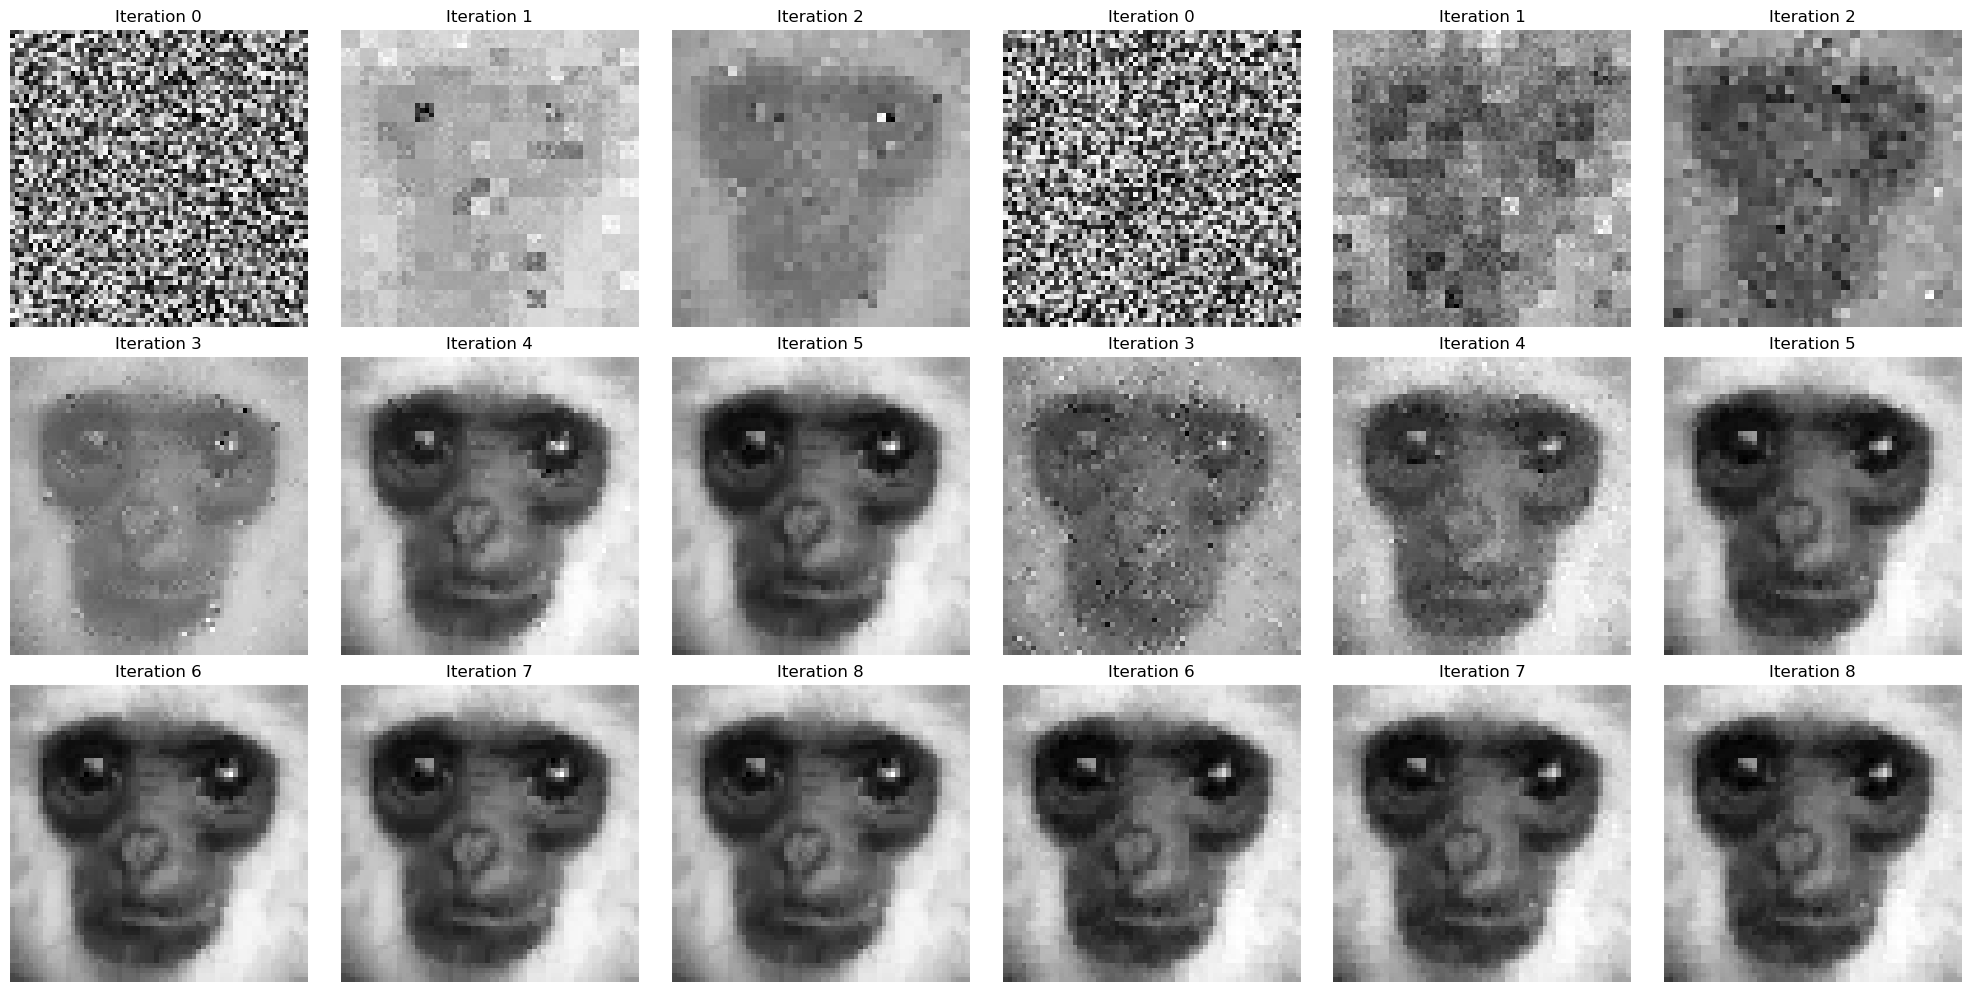

In [58]:
import matplotlib.pyplot as plt

# 假设 iterations1 和 iterations 是两个包含图像数据的列表
# 这里只是示例，请用你的实际数据替换 iterations1 和 iterations

fig, axes = plt.subplots(3, 6, figsize=(20, 10))  # 创建一个3x6的网格


# 显示第二个3x3网格
for i in range(len(iterations)):
    ax = axes[i // 3, i % 3 + 3]  # 计算子图的位置
    ax.imshow(iterations[i], cmap='gray')
    ax.set_title(f'Iteration {i}')
    ax.axis('off')  # 隐藏坐标轴

# 显示第一个3x3网格
for i in range(len(iterations1)):
    ax = axes[i // 3, i % 3]  # 计算子图的位置
    ax.imshow(iterations1[i], cmap='gray')
    ax.set_title(f'Iteration {i}')
    ax.axis('off')  # 隐藏坐标轴





plt.tight_layout()
#plt.savefig('Mean Subtraction')
plt.show()

